# 🛍️ Sales Forecasting Project - Multi-Model Evaluation

This notebook demonstrates sales forecasting using multiple models:
- Random Forest
- XGBoost
- CatBoost

We'll perform EDA, feature extraction, training, and evaluation.

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

## 📂 Load Dataset

In [4]:
# ✅ Change this path if needed
file_path = "sales_data.csv"
df = pd.read_csv(file_path, parse_dates=["Date"])
df.head()

,Store,Date,Promo,Sales
0,Store_1,2022-01-02,1,2747
1,Store_1,2022-01-09,0,2215
2,Store_1,2022-01-16,0,2319
3,Store_1,2022-01-23,0,2152
4,Store_1,2022-01-30,0,2242


## 📊 Data Overview

In [5]:
df.describe()

,Date,Promo,Sales
count,525,525.000000,525.000000
mean,2023-01-01 00:00:00,0.304762,1751.154286
min,2022-01-02 00:00:00,0.000000,377.000000
25%,2022-07-03 00:00:00,0.000000,1214.000000
50%,2023-01-01 00:00:00,0.000000,1593.000000
75%,2023-07-02 00:00:00,1.000000,2275.000000
max,2023-12-31 00:00:00,1.000000,3703.000000
std,NaN,0.460746,686.823697


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Store   525 non-null    object        
 1   Date    525 non-null    datetime64[ns]
 2   Promo   525 non-null    int64         
 3   Sales   525 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 16.5+ KB


## 🧪 Feature Engineering

In [7]:
df["Week"] = df["Date"].dt.isocalendar().week
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df.head()

,Store,Date,Promo,Sales,Week,Month,Year
0,Store_1,2022-01-02,1,2747,52,1,2022
1,Store_1,2022-01-09,0,2215,1,1,2022
2,Store_1,2022-01-16,0,2319,2,1,2022
3,Store_1,2022-01-23,0,2152,3,1,2022
4,Store_1,2022-01-30,0,2242,4,1,2022


## 📈 Sales Trend Overview

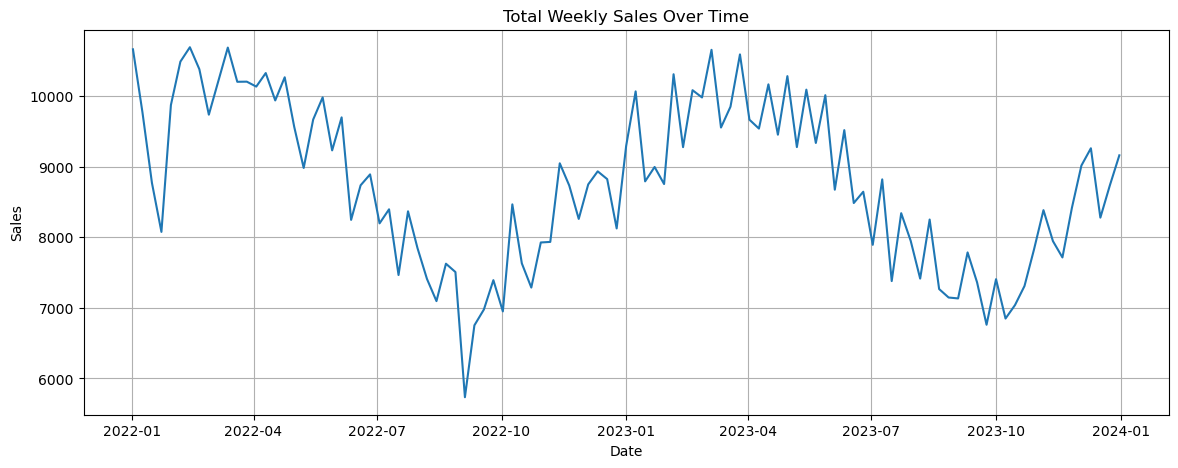

In [8]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=df.groupby("Date")["Sales"].sum())
plt.title("Total Weekly Sales Over Time")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

## 🤖 Model 1: Random Forest, XGBoost, CatBoost

In [9]:

# Features and target
X = df[["Store", "Promo", "Week", "Month", "Year"]]
y = df["Sales"]

categorical_features = ["Store"]
numeric_features = ["Promo", "Week", "Month", "Year"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
], remainder="passthrough")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": mean_squared_error(y_test, preds, squared=False),
        "R2": r2_score(y_test, preds)
    }

# Display results
pd.DataFrame(results).T

,MAE,RMSE,R2
RandomForest,171.734381,214.922825,0.905756
XGBoost,183.506685,243.558186,0.878970
CatBoost,165.705202,212.987168,0.907446


## ✅ Summary & Observations

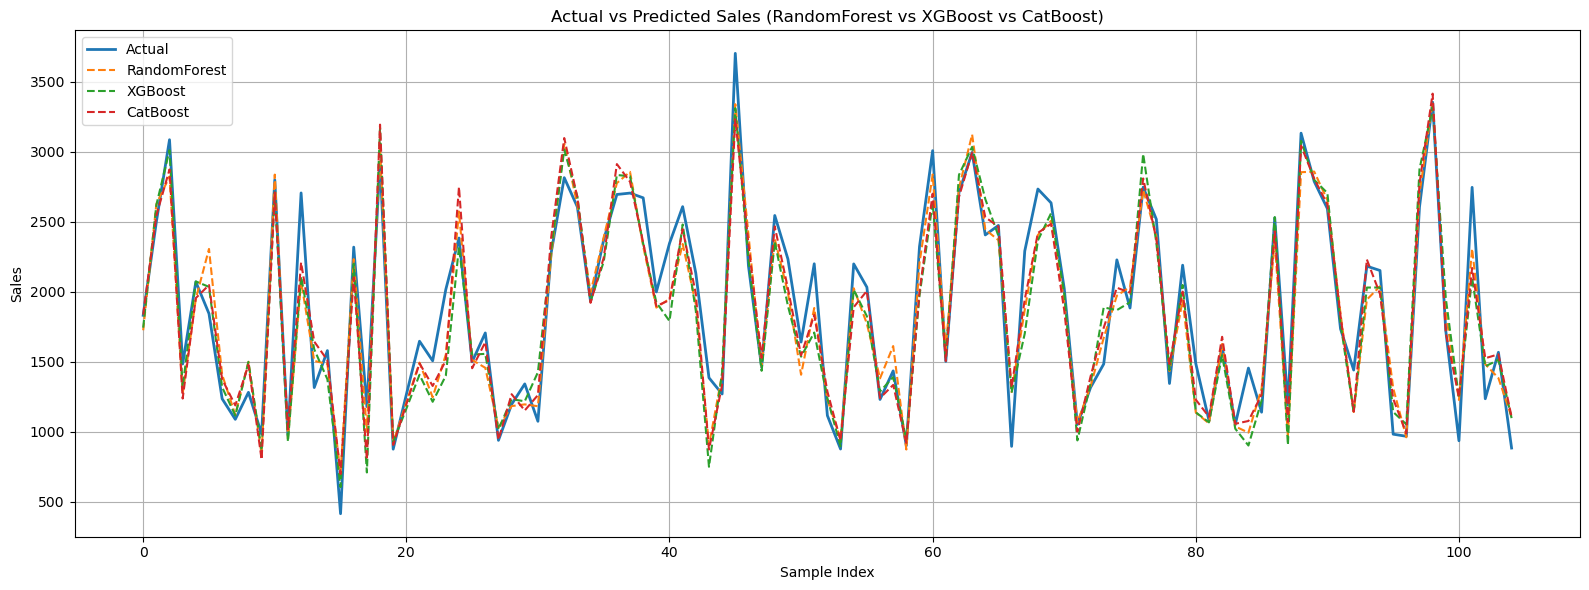

In [12]:
import matplotlib.pyplot as plt

# Store predictions for plotting
predictions_df = pd.DataFrame({"Actual": y_test.reset_index(drop=True)})

# Generate predictions from each model
for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    predictions_df[name] = preds

# Plot the predictions vs actuals
plt.figure(figsize=(16, 6))
plt.plot(predictions_df["Actual"].values, label="Actual", linewidth=2)

plt.plot(predictions_df["RandomForest"].values, label="RandomForest", linestyle='--')
plt.plot(predictions_df["XGBoost"].values, label="XGBoost", linestyle='--')
plt.plot(predictions_df["CatBoost"].values, label="CatBoost", linestyle='--')

plt.title("Actual vs Predicted Sales (RandomForest vs XGBoost vs CatBoost)")
plt.xlabel("Sample Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()